In [ ]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="HeNPARP7EmQTxxVRpewzuqm8b",
    project_name="face-normal-liveness",
    workspace="ahmadirfaan",
)

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [10]:
bs = 24
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train = datasets.ImageFolder("train", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [11]:
len(train_set), len(val_set)

(18015, 3179)

In [5]:
label2cat = data_train.classes
label2cat

# Architecture and Config

In [6]:
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet

class EfficientNetB0(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = EfficientNet.from_name('efficientnet-b0')
#         self.basemodel.set_swish(memory_efficient=False)
        self.freeze()
        self.basemodel._fc = nn.Sequential(
            nn.Linear(1280, output_size)
        )
        
#         self.basemodel.classifier = nn.Sequential(
#             nn.Linear(512, output_size),
#             nn.LogSoftmax(dim=1)
#         )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [9]:
import timm
class VisionTransformer(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.freeze()
        self.basemodel.head = nn.Sequential(
            nn.Linear(768, output_size),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [16]:
config = set_config({
    "output_size": len(data_train.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Training

In [10]:
model_2 = EfficientNetB0(2).to(device)
model_3 = VisionTransformer(2).to(device)

In [11]:
model_2.load_state_dict(torch.load('model fix/effnet.pth', map_location=device))
model_3.load_state_dict(torch.load('model fix/vision_transformer.pth', map_location=device))

<All keys matched successfully>

## Validation Score

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [14]:
bs = 24
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_benchmark = datasets.ImageFolder("val", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)

benchmarkloader = DataLoader(data_benchmark, batch_size=bs)

In [15]:
target2, preds2, y_pred_prob2 = predict(model_2, benchmarkloader, device)
target3, preds3, y_pred_prob3 = predict(model_3, benchmarkloader, device)

In [16]:
preds_majority_voting = []

In [17]:
for target, pred_2, pred_3, prob_2, prob_3 in zip(target2, preds2, preds3, y_pred_prob2, y_pred_prob3):
    vote = pred_2 + pred_3
    if(vote == 2):
        preds_majority_voting.append(1)
    elif(vote == 0):
        preds_majority_voting.append(0)
    else:
        if(max(prob_2) > max(prob_3)):
            preds_majority_voting.append(pred_2)
        else:
            preds_majority_voting.append(pred_3)

In [18]:
print(classification_report(target2, preds_majority_voting, target_names=label2cat))

              precision    recall  f1-score   support

      0_live       0.97      0.97      0.97      1156
     1_spoof       0.99      0.99      0.99      4144

    accuracy                           0.99      5300
   macro avg       0.98      0.98      0.98      5300
weighted avg       0.99      0.99      0.99      5300



In [20]:
cf_matrix = confusion_matrix(target2, preds_majority_voting)
cf_matrix

array([[1127,   29],
       [  37, 4107]])

In [21]:
tn, fp, fn, tp = cf_matrix.ravel()

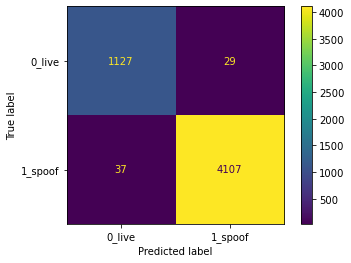

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.4g')

# Calculate Metric

In [23]:
apcer = fp / (tn + fp)
npcer = fn / (fn + tp)

acer = (apcer + npcer) / 2
tpr = tp / (tp + fn)
tnr = tn / (tn+fp)

In [24]:
print(f'APCER / FPR: {apcer*100:.{4}f}')
print(f'NPCER / FNR: {npcer*100:.{4}f}')
print(f'ACER: {acer*100:.{4}f}')
print(f'TPR: {tpr*100:.{4}f}')
print(f'TNR: {tnr*100:.{4}f}')

APCER / FPR: 2.5087
NPCER / FNR: 0.8929
ACER: 1.7008
TPR: 99.1071
TNR: 97.4913


# Challenge

In [41]:
import os
from PIL import Image

In [35]:
all_images = os.listdir('benchmark/benchmark-challenge')

In [36]:
def transform_image(image):
    # Load Image
    img = Image.open(image)
    img = img.convert('RGB')
    
    # Transform Image
    crop_size = 230

    transform = transforms.Compose([
      transforms.Resize((crop_size, crop_size)),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input = transform(img).to(device)
    input = input.unsqueeze(0)

    return input

In [113]:
from torch import nn, optim

In [154]:
def predict_image(img):
    # Support to GPU and CPU
    input = transform_image(img)
    vote = 0
    prob = 0
    for model in [model_1, model_2, model_3]:
        preds = model(input)
#         print(preds)
        _, preds_out = torch.max(preds, 1)
        preds_out = preds_out.cpu().numpy()
        probs = nn.functional.softmax(preds.detach(), dim=1).cpu().numpy()
        vote += preds_out[0]
        prob += probs[0][preds_out[0]]
#         print(probs[0][preds_out[0]])
#     print(prob/3)
    if(vote >= 2):
        return [img.split('/')[-1], 0, prob/3]
    else:
        return [img.split('/')[-1], 1, prob/3]

In [155]:
df = []

for image in all_images:
    df.append(predict_image('benchmark/benchmark-challenge/'+image))

In [123]:
predict_image('img1.jpg')

['img1.jpg', 'spoof', 0.8833582997322083]

In [156]:
import pandas as pd

In [157]:
df_chal = pd.DataFrame(df, columns=['image', 'prediction', 'score'])

In [158]:
df_chal.to_csv('liveness_challenge.csv', index=False)

In [153]:
df_chal[df_chal.prediction == 'live']

image prediction     score
4    jufmixttxpgeksj.jpg       live  0.987188
6    dazynxijyufwtdi.jpg       live  0.886405
8    qzedhytmnvarils.jpg       live  0.869849
19   pcijlaazoacssyn.jpg       live  0.784862
31   gfacuzdnchxzfkj.jpg       live  0.962611
..                   ...        ...       ...
982  nqienegixvdtdjg.jpg       live  0.928888
983  gdmtcyrevkedpuq.jpg       live  0.939770
984  mrihclqzslzzwrp.jpg       live  0.976754
992  bvzzdsciujqwzzg.jpg       live  0.857086
997  wxrtabavdezeexe.jpg       live  0.826554

[149 rows x 3 columns]